# load the packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# load the grid

In [4]:
# define basin we want
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
# if whole:
#     mask = (mymsk < 5) | (mymsk==6) 
# else:
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
# test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [6]:
mymsk3 = np.tile(mymsk[np.newaxis,:,:],(nz,1,1)) * mygrid['hFacC']
mymsk3.shape

(50, 1350, 270)

In [13]:
# # make mymsk the whole arctic
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)
mask = mymsk < 7 
mask = (mymsk < 5) | (mymsk==6) 
mymsk[mask] = 1
mymsk[~mask] = np.nan

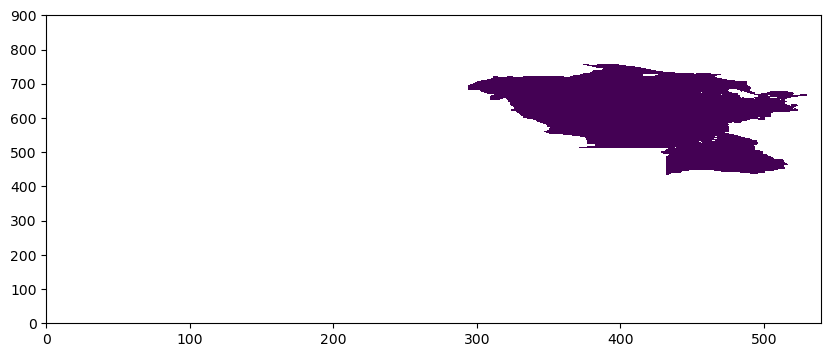

In [14]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

# timesteps

In [15]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# the following will need to be modified if we look at multiple time steps
# dt = datetimes[1]-datetimes[0]   # days
# dt = dt.total_seconds()

# ocean and ice
AB_gT=0
AB_gS=0

In [16]:
allyears = np.arange(2003,2018,1)
# allyears = np.arange(2011,2014,1)

In [17]:
# for one year
# tsstr = tsstr[:6]
# datetimes = datetimes[:6]
# datetimes.shape

In [18]:
# # 'datetimes' is a list of datetime objects
# dt = [(datetimes[i+1] - datetimes[i]).total_seconds() for i in range(len(datetimes) - 1)]
# dt = np.array(dt)
# dt.shape


# mygrid['RF'][:19]
dterm = 19                 # set a terminal depth for freshwater and heat calculations

# load the files for a time series of FW content

In [19]:
# loop through the years to create the timeseries
alldatetimes = np.array([])
FW_times = np.array([])
Heat_times = np.array([])  # this does not make sense as variable name

for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the volume values

    # for mass tendency (m^3/s) - time is not yet included in this block
    file_name = 'budg2d_snap_set1'
    
    # assuming all files are structured the same
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
    # try to read this with rec
    fldlist = np.array(meta_budg2d_snap_set1['fldList'])
    varnames = np.array(['ETAN'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    # set for all months
    vol = np.full((len(tsstr),nz, ny, nx),np.nan)
    ETANS = np.full((len(tsstr),ny,nx),np.nan)
    print("volume allocation shape",vol.shape)
    
    for t in range(len(tsstr)):
        t1 = tsstr[t]
        read = [int(t1)]
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    
        # choose by basin
        ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]
    
        # ocean
        if debug:
            print(read,its[0],its[1]) # these iteration numbers should be the same as read
    
        # 3D, with rStar:
        tmpvol = np.zeros((nz, ny, nx))
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
            tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = np.zeros((ny, nx))
        else:    # 4/22 look at this one
            if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
                tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
                tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
    
            # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
            tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) #* mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3
    
        vol[t,:,:,:] = tmpvol
    
    #print(vol.shape)


    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))
    
    # divide first two and second two by dt
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']


    # calculate the total heat of this layer as a sum
    heat_content = np.full(len(datetimes),np.nan)

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        thisTHETADR = THETADR[i] * mymsk
        thisheat = thisTHETADR * myparms['rcp']   # degC.m * J/m^3.degC = J/m^2
        thisheat = thisheat[:dterm]   # upper 254 m

        heat_content[i] = np.nansum(thisheat)  # J/m^2
        

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    sref = 34.8#41.05      # PSU
    filter = drf3d.copy() * mygrid['hFacC']
    filter[filter >= 254] = np.nan
    filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to 254 m based on the np.where(np.cumsum(mygrid['DRF'])<254)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than 254 m
        saltnorm = 1-(SALT[i]/sref)
        FWvol = vol[i] * (1-SALT[i]/sref)   # m^3 * 1
        FWvol /=  RAC3    # m
        FWvol = FWvol[:dterm]
        
        # vertically integrate
        FWcontent[i] = np.nansum(FWvol,axis=0) * mymsk          # summing in depth for the upper layer, m

    ####
    # append to big list

    for i in range(len(datetimes)):
        FW_times = np.append(FW_times,np.nansum(FWcontent[i]))
        #print(np.nansum(FWcontent[i]))
        Heat_times = np.append(Heat_times,heat_content[i])
        #print(heat_content[i])
        #print(np.nansum(FWcontent[i]))

        alldatetimes = np.append(alldatetimes,datetimes[i])

    print()

2003
volume allocation shape (12, 50, 1350, 270)

2004
volume allocation shape (12, 50, 1350, 270)

2005
volume allocation shape (12, 50, 1350, 270)

2006
volume allocation shape (12, 50, 1350, 270)

2007
volume allocation shape (12, 50, 1350, 270)

2008
volume allocation shape (12, 50, 1350, 270)

2009
volume allocation shape (12, 50, 1350, 270)

2010
volume allocation shape (12, 50, 1350, 270)

2011
volume allocation shape (12, 50, 1350, 270)

2012
volume allocation shape (12, 50, 1350, 270)

2013
volume allocation shape (12, 50, 1350, 270)

2014
volume allocation shape (12, 50, 1350, 270)

2015
volume allocation shape (12, 50, 1350, 270)

2016
volume allocation shape (12, 50, 1350, 270)

2017
volume allocation shape (12, 50, 1350, 270)



In [20]:
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.array([])

for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2


        # get the total SIarea for that time
        SIareas = np.append(SIareas,np.nansum(SIarea[i,:,:]))
        alldatetimes = np.append(alldatetimes,datetimes[i])

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


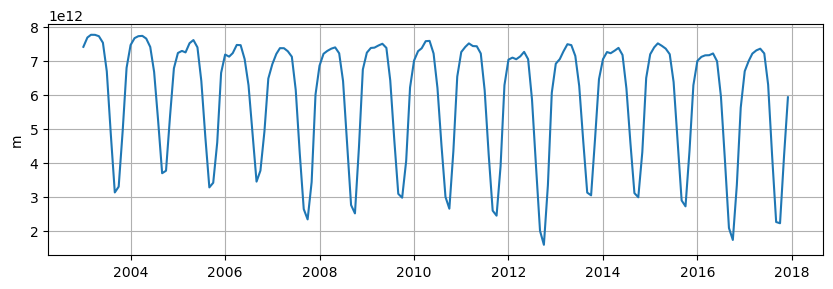

In [21]:
# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,3))

plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space

ax = plt.subplot(111)
ax.plot(alldatetimes,SIareas)# ,label='FW Content Upper 254 m')
# ax.set_title("FW")
ax.set_ylabel("m")
ax.grid()
# ax.legend()

In [22]:
# do the masking and get a singular value
# alldatetimes[-60:]

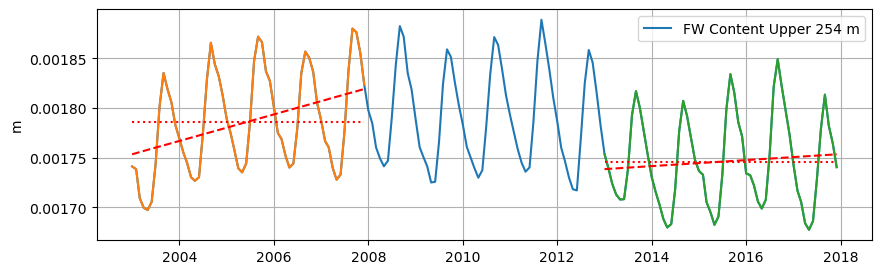

In [23]:
# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,3))

plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space

ax = plt.subplot(111)
ax.plot(alldatetimes,FW_times,label='FW Content Upper 254 m')
# ax.set_title("FW")
ax.set_ylabel("m")
ax.grid()
ax.legend()

# add two trendlines to this fig
coefficients = np.polyfit(np.arange(len(alldatetimes[:60])), FW_times[:60], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[:60])))
ax.plot(alldatetimes[:60], FW_times[:60], label="mean FW, m")
ax.plot(alldatetimes[:60], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(FW_times[:60])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[:60], avgline, color='red', linestyle=':')

# do the same for 2013-17
coefficients = np.polyfit(np.arange(len(alldatetimes[-60:])), FW_times[-60:], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[-60:])))
ax.plot(alldatetimes[-60:], FW_times[-60:], label="mean FW, m")
ax.plot(alldatetimes[-60:], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(FW_times[-60:])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[-60:], avgline, color='red', linestyle=':')

# plt.savefig(path + "FWtimeseries.png",dpi=300)

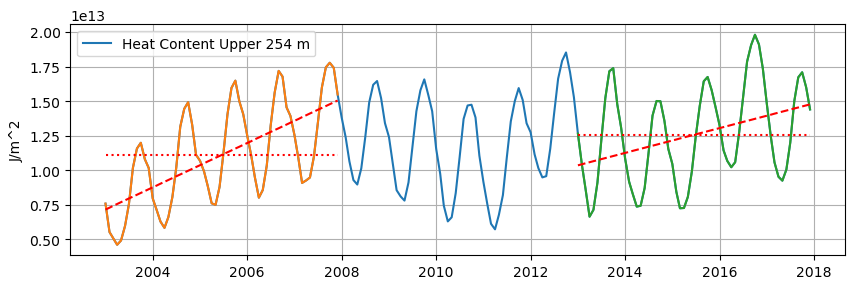

In [35]:
# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,3))

plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space

ax = plt.subplot(111)
ax.plot(alldatetimes,Heat_times,label='Heat Content Upper 254 m')
# ax.set_title("FW")
ax.set_ylabel("J/m^2")
ax.grid()
ax.legend()

# add two trendlines to this fig
coefficients = np.polyfit(np.arange(len(alldatetimes[:60])), Heat_times[:60], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[:60])))
ax.plot(alldatetimes[:60], Heat_times[:60], label="total heat content")
ax.plot(alldatetimes[:60], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(Heat_times[:60])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[:60], avgline, color='red', linestyle=':')

# do the same for 2013-17
coefficients = np.polyfit(np.arange(len(alldatetimes[-60:])), Heat_times[-60:], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[-60:])))
ax.plot(alldatetimes[-60:], Heat_times[-60:], label="mean FW, m")
ax.plot(alldatetimes[-60:], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(Heat_times[-60:])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[-60:], avgline, color='red', linestyle=':')

# plt.savefig(path + "FWtimeseries.png",dpi=300)

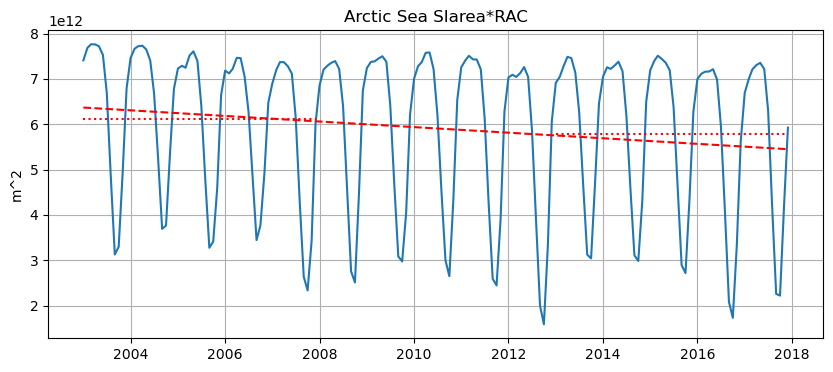

In [25]:
# try to add these on the same plot with different axes
fig = plt.figure(figsize=(10,4))

#############################
# add subplot for sea ice area - we could probably just add the mean lines for this rather than doing the trendline
ax = plt.subplot(111)
ax.plot(alldatetimes,SIareas)
# ax.set_ylabel("m^2/m^2")
ax.grid()

# add two trendlines to this fig
# coefficients = np.polyfit(np.arange(len(alldatetimes[:60])), SIareas[:60], 1)
# trendline = np.polyval(coefficients, np.arange(len(alldatetimes[:60])))
# ax.plot(alldatetimes[:60], SIareas[:60], label="total heat content")
# ax.plot(alldatetimes[:60], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(SIareas[:60])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[:60], avgline, color='red', linestyle=':')

# do the same for 2013-17

avgline = np.nanmean(SIareas[-60:])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[-60:], avgline, color='red', linestyle=':')

# set the labels
ax.set_title("Arctic Sea SIarea*RAC")
ax.set_ylabel("m^2")

# add a trendline for the whole thing
coefficients = np.polyfit(np.arange(len(alldatetimes[:])), SIareas[:], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[:])))
# ax.plot(alldatetimes[:], SIareas[:], label="Total SIarea")
ax.plot(alldatetimes[:], trendline, label="Trendline", color='red', linestyle='--')

#############################
# plt.savefig(path + "BarentsS_SIarea_timeseries.png",dpi=300)

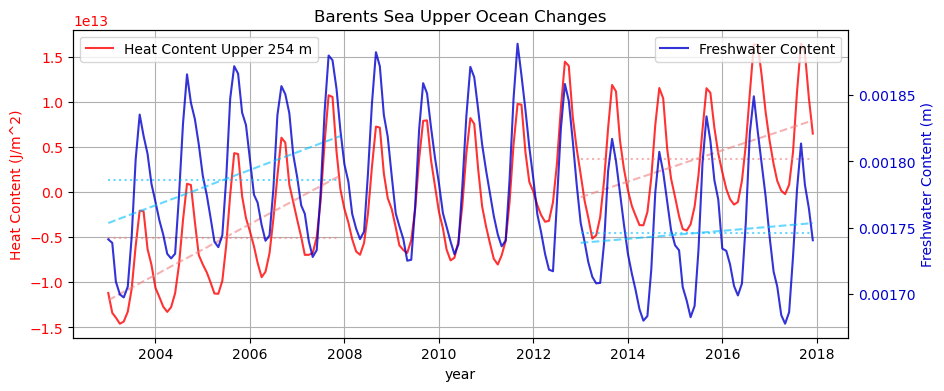

In [27]:
fig, ax1 = plt.subplots()

alpha = 0.6
alphabold = .8

# First plot (left y-axis): Heat Content
ax1.plot(alldatetimes, Heat_times, label='Heat Content Upper 254 m', color='r',alpha=alphabold)
ax1.set_xlabel('year')
ax1.set_ylabel('Heat Content (J/m^2)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Add trendline and mean line for Heat Content
coefficients_heat_start = np.polyfit(np.arange(len(alldatetimes[:60])), Heat_times[:60], 1)
trendline_heat_start = np.polyval(coefficients_heat_start, np.arange(len(alldatetimes[:60])))
ax1.plot(alldatetimes[:60], trendline_heat_start, color='lightcoral', linestyle='--',alpha=alpha)#, label="Trendline (start)")
avgline_heat_start = np.nanmean(Heat_times[:60])
ax1.plot(alldatetimes[:60], np.full(60, avgline_heat_start), color='lightcoral', linestyle=':',alpha=alpha)

coefficients_heat_end = np.polyfit(np.arange(len(alldatetimes[-60:])), Heat_times[-60:], 1)
trendline_heat_end = np.polyval(coefficients_heat_end, np.arange(len(alldatetimes[-60:])))
ax1.plot(alldatetimes[-60:], trendline_heat_end, color='lightcoral', linestyle='--',alpha=alpha)#, label="Trendline (end)")
avgline_heat_end = np.nanmean(Heat_times[-60:])
ax1.plot(alldatetimes[-60:], np.full(60, avgline_heat_end), color='lightcoral', linestyle=':',alpha=alpha)

# Second plot (right y-axis): Freshwater Content
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(alldatetimes, FW_times, label='Freshwater Content', color='mediumblue',alpha=alphabold)
ax2.set_ylabel('Freshwater Content (m)', color='mediumblue')
ax2.tick_params(axis='y', labelcolor='mediumblue')

# Add trendline and mean line for Freshwater Content
coefficients_fw_start = np.polyfit(np.arange(len(alldatetimes[:60])), FW_times[:60], 1)
trendline_fw_start = np.polyval(coefficients_fw_start, np.arange(len(alldatetimes[:60])))
ax2.plot(alldatetimes[:60], trendline_fw_start, color='deepskyblue', linestyle='--',alpha=alpha)#, label="Trendline (start)")
avgline_fw_start = np.nanmean(FW_times[:60])
ax2.plot(alldatetimes[:60], np.full(60, avgline_fw_start), color='deepskyblue', linestyle=':',alpha=alpha)

coefficients_fw_end = np.polyfit(np.arange(len(alldatetimes[-60:])), FW_times[-60:], 1)
trendline_fw_end = np.polyval(coefficients_fw_end, np.arange(len(alldatetimes[-60:])))
ax2.plot(alldatetimes[-60:], trendline_fw_end, color='deepskyblue', linestyle='--',alpha=alpha)#, label="Trendline (end)")
avgline_fw_end = np.nanmean(FW_times[-60:])
ax2.plot(alldatetimes[-60:], np.full(60, avgline_fw_end), color='deepskyblue', linestyle=':',alpha=alpha)

# Set legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title("Barents Sea Upper Ocean Changes")

ax1.grid()

# plt.show()
# plt.savefig(path + "BarentsS_heatsalt_timeseries.png",dpi=300)

In [26]:
# we will want to load only one file at a time so that we don't overload the memory
# load these files
    # Ocean temperature, air temperature, sensible heat are all things to look at
    # Sea ice

In [27]:
# let's do this for sea ice alone so we can look here
# we'll set the datetimes each time so that we can look each time without loading all the files
# tsstr

In [ ]:
# FIX NAMES! THESE ARE NOT MEDIAN!!!

In [ ]:
# can do for sensible heat flux given from the atmosphere: "EXFhs from exf_zflux_set1"
# note this is not the total heat RECEIVED by the ocean

# try to make a plot with both

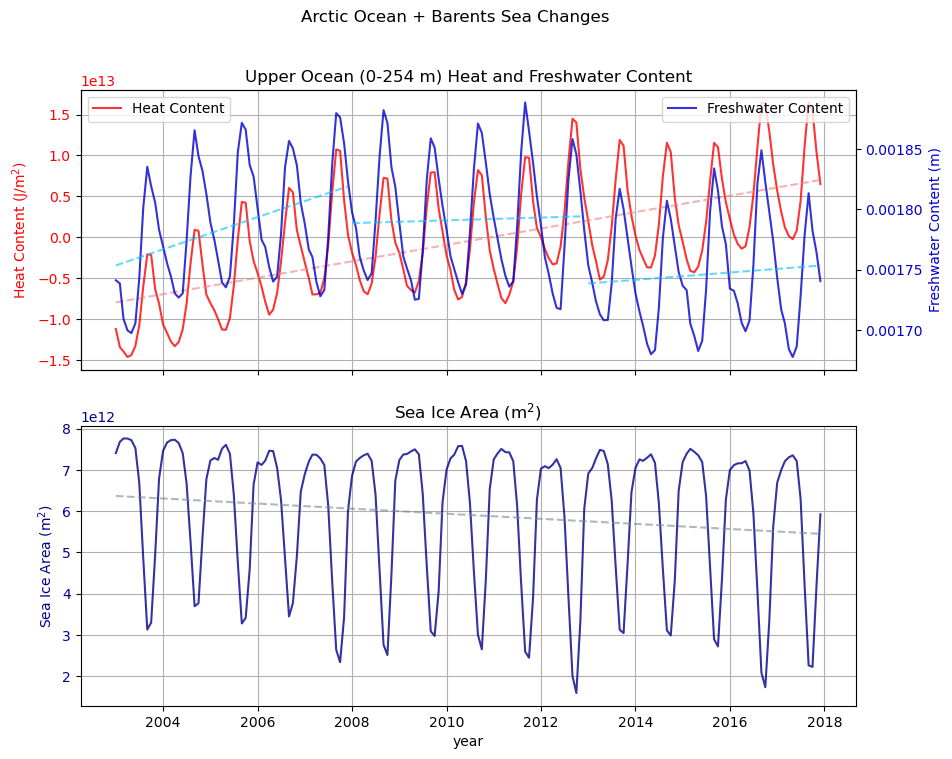

In [50]:
# Create a figure with two subplots, sharing the same x-axis
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

alpha = 0.6
alphabold = .8

# First plot (top): Heat Content and Freshwater Content with trendlines
# First plot (left y-axis): Heat Content
ax1.plot(alldatetimes, Heat_times, label='Heat Content', color='r', alpha=alphabold)
ax1.set_ylabel(r'Heat Content $\mathrm{(J/m^2)}$', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid()

# Add trendline and mean line for Heat Content
# coefficients_heat_start = np.polyfit(np.arange(len(alldatetimes[:60])), Heat_times[:60], 1)
# trendline_heat_start = np.polyval(coefficients_heat_start, np.arange(len(alldatetimes[:60])))
# ax1.plot(alldatetimes[:60], trendline_heat_start, color='lightcoral', linestyle='--', alpha=alpha)

# coefficients_heat_mid = np.polyfit(np.arange(len(alldatetimes[60:120])), Heat_times[60:120], 1)
# trendline_heat_mid = np.polyval(coefficients_heat_mid, np.arange(len(alldatetimes[60:120])))
# ax1.plot(alldatetimes[60:120], trendline_heat_mid, color='lightcoral', linestyle='--', alpha=alpha)

# coefficients_heat_end = np.polyfit(np.arange(len(alldatetimes[-60:])), Heat_times[-60:], 1)
# trendline_heat_end = np.polyval(coefficients_heat_end, np.arange(len(alldatetimes[-60:])))
# ax1.plot(alldatetimes[-60:], trendline_heat_end, color='lightcoral', linestyle='--', alpha=alpha)

coefficients_heat_end = np.polyfit(np.arange(len(alldatetimes[:])), Heat_times[:], 1)
trendline_heat_end = np.polyval(coefficients_heat_end, np.arange(len(alldatetimes[:])))
ax1.plot(alldatetimes[:], trendline_heat_end, color='lightcoral', linestyle='--', alpha=alpha)

########################################################################################################################
# Second plot (right y-axis): Freshwater Content
ax2 = ax1.twinx()  # Create a second y-axis for the first plot
ax2.plot(alldatetimes, FW_times, label='Freshwater Content', color='mediumblue', alpha=alphabold)
ax2.set_ylabel('Freshwater Content (m)', color='mediumblue')
ax2.tick_params(axis='y', labelcolor='mediumblue')

# Add trendline and mean line for Freshwater Content
coefficients_fw_start = np.polyfit(np.arange(len(alldatetimes[:60])), FW_times[:60], 1)
trendline_fw_start = np.polyval(coefficients_fw_start, np.arange(len(alldatetimes[:60])))
ax2.plot(alldatetimes[:60], trendline_fw_start, color='deepskyblue', linestyle='--', alpha=alpha)

coefficients_fw_mid = np.polyfit(np.arange(len(alldatetimes[60:120])), FW_times[60:120], 1)
trendline_fw_mid = np.polyval(coefficients_fw_mid, np.arange(len(alldatetimes[60:120])))
ax2.plot(alldatetimes[60:120], trendline_fw_mid, color='deepskyblue', linestyle='--', alpha=alpha)

coefficients_fw_end = np.polyfit(np.arange(len(alldatetimes[-60:])), FW_times[-60:], 1)
trendline_fw_end = np.polyval(coefficients_fw_end, np.arange(len(alldatetimes[-60:])))
ax2.plot(alldatetimes[-60:], trendline_fw_end, color='deepskyblue', linestyle='--', alpha=alpha)

# Set legends for both plots in the first subplot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title("Upper Ocean (0-254 m) Heat and Freshwater Content")

# Second subplot (bottom): A different timeseries of ice
########################################################################################################################
ax3.plot(alldatetimes, SIareas, label='Another Timeseries', color='darkblue', alpha=alphabold)
ax3.set_xlabel('year')
ax3.set_ylabel('Sea Ice Area $\mathrm{(m^2)}$', color='darkblue')
ax3.tick_params(axis='y', labelcolor='darkblue')

# Add trendline and mean line for the second timeseries
coefficients_another_start = np.polyfit(np.arange(len(alldatetimes)), SIareas, 1)
trendline_another_start = np.polyval(coefficients_another_start, np.arange(len(alldatetimes)))
ax3.plot(alldatetimes, trendline_another_start, color='lightslategray', linestyle='--', alpha=alpha)
# avgline_another_start = np.nanmean(SIareas)
# ax3.plot(alldatetimes, np.full(60, avgline_another_start), color='lightslategray', linestyle=':', alpha=alpha)

# Add legend for the second subplot
# ax3.legend(loc='upper left')
ax3.grid()
ax3.set_title(r'Sea Ice Area $\mathrm{(m^2)}$')

# Set overall title for the figure
fig.suptitle("Arctic Ocean + Barents Sea Changes")

# Show or save the plot
# plt.show()
plt.savefig(path + "Arctic_timeseries_proposal.png", dpi=300)